In [1]:
## This is a demo for atlas
## Author : Avadesh Meduri
## Date : 06/04/2022
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from mpc.abstract_cyclic_gen1 import AbstractGaitGen
from robot_properties_atlas.config import AtlasConfig
from py_biconvex_mpc.ik_utils.abstract_gait_generator import AbstractGaitGenerator

from matplotlib import pyplot as plt

import pinocchio as pin

import numpy as np
from motions.weight_abstract import BiconvexMotionParams
from robot_properties_solo.config import Solo12Config

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<hpp::fcl::CollisionGeometry> already registered; second conversion method ignored.


In [2]:
robot = AtlasConfig.buildRobotWrapper()
rmodel = robot.model
rdata = robot.data
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
## robot config and init
pin_robot = AtlasConfig.buildRobotWrapper()
urdf_path = AtlasConfig.urdf_path

n_eff = 10
eff_names = ["l_foot_lt", "l_foot_rt", "l_foot_lb", "l_foot_rb", "r_foot_lt", "r_foot_rt", "r_foot_lb", "r_foot_rb"]
hip_names = ["l_leg_hpz", "l_leg_hpz", "l_leg_hpz", "l_leg_hpz", "r_leg_hpz", "r_leg_hpz", "r_leg_hpz", "r_leg_hpz"]
q0 = np.array(AtlasConfig.initial_configuration)
q0[0:2] = 0.0

v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

v_des = np.array([0.0,0.0,0.0])
w_des = 0.0

plan_freq = 0.05 # sec
update_time = 0.0 # sec (time of lag)

In [4]:
gg = AbstractGaitGen(urdf_path, eff_names, hip_names, x0, plan_freq, q0)

robot_mass: 2.5


In [5]:
#### walk #########################################
walk = BiconvexMotionParams("atlas", "walk")

# Cnt
walk.gait_period = 0.8
walk.stance_percent = n_eff*[0.6,]
walk.gait_dt = 0.05
walk.phase_offset = int(0.5*n_eff)*[0.0,] + int(0.5*n_eff)*[0.5,] 

# IK
walk.state_wt = np.array([1e2, 1e2, 1e2] + [1000] * 3 + [1.0] * (pin_robot.model.nv - 6) \
                         + [0.00] * 3 + [100] * 3 + [.1] *(pin_robot.model.nv - 6))

walk.ctrl_wt = [0, 0, 1] + [1, 1, 1] + [5.0] *(rmodel.nv - 6)

walk.swing_wt = [0*1e5, 0*1e5]
walk.cent_wt = [5e+1, 1e+2]
walk.step_ht = 0.3
walk.nom_ht = 1.12
walk.reg_wt = [5e-2, 1e-5]

# Dyn
walk.W_X =     np.array([5e0, 1e0, 1e+5, 1e-4, 1e-4, 2e0, 3e+0, 1e+0, 3e+0])
walk.W_X_ter = 10.*np.array([5e0, 1e0, 1e+5, 1e-1, 1e-1, 2e2, 1e+1, 1e+1, 1e+1])
walk.W_F = np.array(8*[1e1, 1e1, 1e1])
walk.rho = 5e4

walk.ori_correction = [0.0, 0.0, 0.0]
walk.gait_horizon = 3

# Gains
walk.kp = 100.5
walk.kd = 5.0

In [6]:
gg.update_gait_params(walk, 0)

Initialized Kino-Dyn planner


In [7]:
viz.viewer.jupyter_cell()

max iters


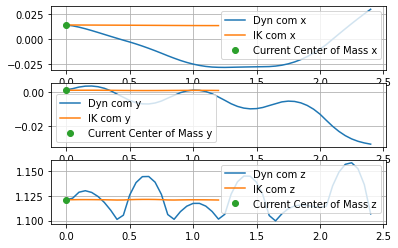

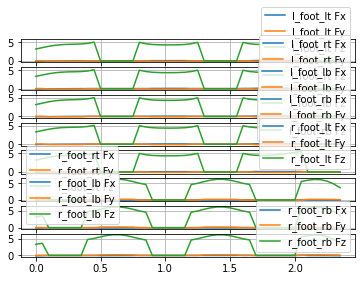

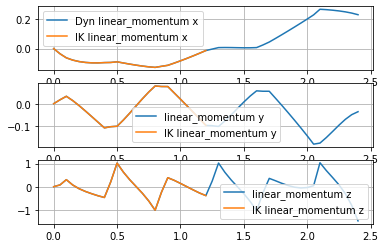

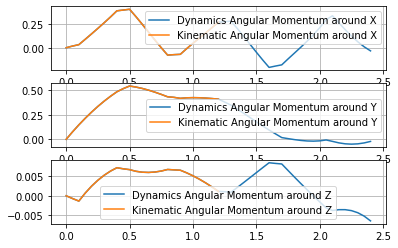

In [10]:
sim_t = 0.0
sim_dt = 0.05
index = 0
pln_ctr = 0
plan_freq = 1.0 # sec
update_time = 0.0 # sec (time of lag)
q = q0
v = v0


for o in range(1):
    xs, us, f = gg.optimize(q, v, sim_t, v_des, w_des)
    gg.plot(q, v)
    for ind in range(int(plan_freq/(sim_dt))):
        viz.display(xs[ind][:robot.model.nq])
        time.sleep(0.01)

    q = xs[int(plan_freq/sim_dt)-1][0:pin_robot.model.nq]
    v = xs[int(plan_freq/sim_dt)-1][pin_robot.model.nq:]
    sim_t += plan_freq